In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# discsrete kalman filter

In [2]:
def __kalman_forward_update__(xhat_fm, P_fm, y, u, A, B, C, R, Q):
    '''
    H = C
    Phi = A
    Gamma = B
    '''
    I = np.matrix(np.eye(A.shape[0]))
    gammaW = np.matrix(np.eye(A.shape[0]))

    K_f = P_fm*C.T*(C*P_fm*C.T + R).I

    
    xhat_fp = xhat_fm + K_f*(y - C*xhat_fm)

    P_fp = (I - K_f*C)*P_fm

    xhat_fm = A*xhat_fp + B*u

    P_fm = A*P_fp*A.T + gammaW*Q*gammaW.T

    return xhat_fp, xhat_fm, P_fp, P_fm

def __kalman_forward_filter__(xhat_fm, P_fm, y, u, A, B, C, R, Q):
    assert type(xhat_fm) is np.matrix
    assert type(P_fm) is np.matrix
    assert type(A) is np.matrix
    assert type(B) is np.matrix
    assert type(C) is np.matrix
    assert type(R) is np.matrix
    assert type(Q) is np.matrix
    assert type(y) is np.matrix
    if u is None:
        u = np.matrix(np.zeros([B.shape[1], y.shape[1]]))
    assert type(u) is np.matrix
    
    N = y.shape[1]

    xhat_fp = None
    P_fp = []
    P_fm = [P_fm]

    for i in range(y.shape[1]):
        _xhat_fp, _xhat_fm, _P_fp, _P_fm = __kalman_forward_update__(xhat_fm[:, -1], P_fm[-1], y[:, i], u[:, i], 
                                                                 A, B, C, R, Q)
        if xhat_fp is None:
            xhat_fp = _xhat_fp
        else:
            xhat_fp = np.hstack((xhat_fp, _xhat_fp))
        xhat_fm = np.hstack((xhat_fm, _xhat_fm))
        
        P_fp.append(_P_fp)
        P_fm.append(_P_fm)

    return xhat_fp, xhat_fm, P_fp, P_fm

def __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A):
    N = xhat_fp.shape[1]

    xhat_smooth = copy.copy(xhat_fp)
    P_smooth = copy.copy(P_fp)
    for t in range(N-2, -1, -1):
        L = P_fp[t]*A.T*P_fm[t].I
        xhat_smooth[:,t] = xhat_fp[:,t] + L*(xhat_smooth[:,t+1] - xhat_fm[:,t+1])
        P_smooth[t] = P_fp[t] - L*(P_smooth[t+1] - P_fm[t+1])
    
    return xhat_smooth, P_smooth

# create some data

In [3]:
dt = 0.01
t = np.arange(0, 60, dt)

In [4]:
accel_true = np.sin(2*t) + np.sin(2.5*t) + 0.0001*t**2
noise = np.random.normal(0, 0.5, len(accel_true))
accel_noisy = accel_true + noise

Text(0.5,0,'time')

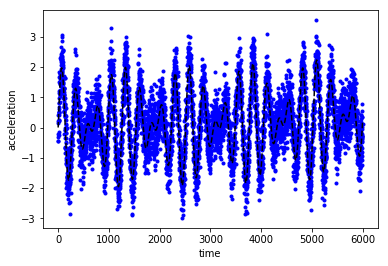

In [5]:
plt.plot(accel_noisy, '.', color='blue')
plt.plot(accel_true, '--', color='black')
plt.ylabel('acceleration')
plt.xlabel('time')

In [6]:
vel_true = np.cumsum(accel_true)*dt
noise = np.random.normal(0, 1, len(accel_true))
vel_noisy = vel_true + noise

Text(0.5,0,'time')

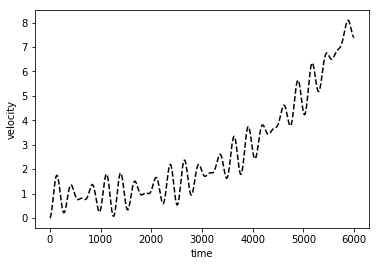

In [7]:
plt.plot(vel_true, '--', color='black')
plt.ylabel('velocity')
plt.xlabel('time')

# kalman filter with only acceleration known

In [8]:
# The dynamics
A = np.matrix([[1, dt], [0, 1]])
B = np.matrix([[0], [1]])
C = np.matrix([[0, 1]])

# These values determine how much smoothing there is.. feel free to fiddle with these numbers
R = np.matrix([[1e-2]])
Q = np.matrix(np.diag([1e-1, 10]))

In [9]:
# initialize
x0 = np.matrix([[0], [0]])
P0 = 10*np.matrix(np.eye(2))

# measurements = acceleration
y = np.matrix(accel_noisy[0:-1])

# control = change in acceleration
u = np.matrix(np.diff(accel_noisy)/dt)

# forward kalman filter
xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, y, u, A, B, C, R, Q)

# kalman smooth
xhat_smooth, P_smooth = __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A)

Text(0,0.5,'velcity')

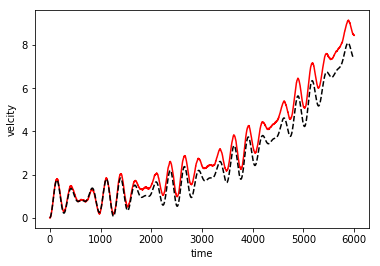

In [10]:
plt.plot(xhat_smooth[0,:].T, color='red') # estimates
plt.plot(vel_true, '--', color='black') # actual
plt.xlabel('time')
plt.ylabel('velcity')

Text(0,0.5,'error')

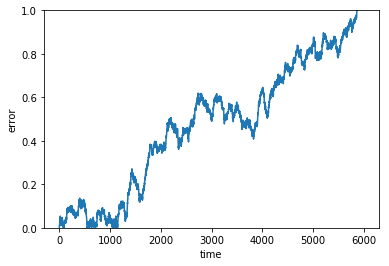

In [11]:
error = np.abs( np.ravel(xhat_smooth[0,:].T)   -   vel_true[1:])
plt.plot(error)
plt.ylim(0, 1)
plt.xlabel('time')
plt.ylabel('error')

### Note: error increases, since we are just integrating a noisy acceleration signal

# Kalman fitler with acceleration and a very noisy velocity estimate

Text(0.5,0,'time')

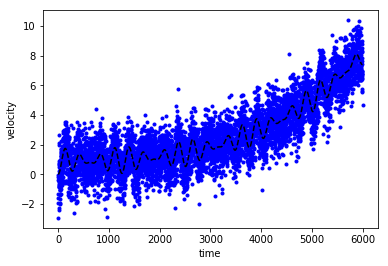

In [12]:
plt.plot(vel_noisy, '.', color='blue')
plt.plot(vel_true, '--', color='black')
plt.ylabel('velocity')
plt.xlabel('time')

In [13]:
# The dynamics
A = np.matrix([[1, dt], [0, 1]])
B = np.matrix([[0], [1]])
C = np.matrix([[1,0 ], [0, 1]]) ### changed

# These values determine how much smoothing there is.. feel free to fiddle with these numbers
R = np.matrix(np.diag([10, 1e-2])) ### changed
Q = np.matrix(np.diag([1e-1, 10]))

In [14]:
# initialize
x0 = np.matrix([[0], [0]])
P0 = 10*np.matrix(np.eye(2))

# measurements = acceleration
y = np.matrix(np.vstack((vel_noisy[0:-1], accel_noisy[0:-1]))) ### changed

# control = change in acceleration
u = np.matrix(np.diff(accel_noisy)/dt)

# forward kalman filter
xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, y, u, A, B, C, R, Q)

# kalman smooth
xhat_smooth, P_smooth = __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A)

Text(0,0.5,'velocity')

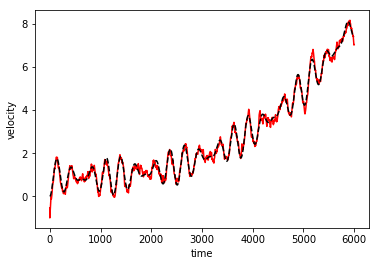

In [15]:
plt.plot(xhat_smooth[0,:].T, color='red') # estimates
plt.plot(vel_true, '--', color='black') # actual
plt.xlabel('time')
plt.ylabel('velocity')

Text(0,0.5,'error')

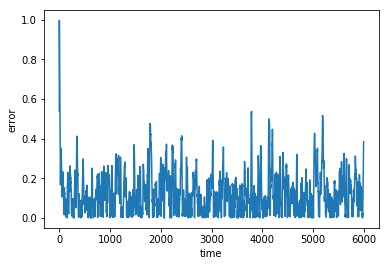

In [16]:
error = np.abs( np.ravel(xhat_smooth[0,:].T)   -   vel_true[1:])
plt.plot(error)
plt.xlabel('time')
plt.ylabel('error')

### Note: adding a very noisy velocity estimate removes the integration error